In [1]:
import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

D:\zzyAnaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#定义series_to_supervised()函数
#将时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
df_s=pd.read_csv("E:\git\dsmp-2024-group22\data_preprocess\DATA\sperated_tapes.csv",parse_dates=['period'],index_col='period')
df_s=df_s.drop("Unnamed: 0",axis=1)
df_s=df_s.dropna()
# df_s=df_s.sort_values(by='period')
df_s=df_s.drop(["Volume"],axis=1)

In [17]:
df_s[4000:]

,max_price,min_price,open_price,close_price
period,,,,
2025-04-28-1,160,140,158,153
2025-04-28-2,161,144,152,160
2025-04-28-3,162,142,158,161
2025-04-28-4,162,141,161,160
2025-04-28-5,160,140,160,154
...,...,...,...,...
2025-07-01-46,113,93,109,110
2025-07-01-47,113,93,109,109
2025-07-01-48,113,93,109,107


In [18]:
values=df_s.values
values=values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.555944  , 0.55714285, 0.5819398 , 0.56      ],
       [0.55244756, 0.55357146, 0.5719063 , 0.5766667 ],
       [0.555944  , 0.55357146, 0.58862877, 0.5366667 ],
       ...,
       [0.006993  , 0.        , 0.05351171, 0.04666668],
       [0.006993  , 0.        , 0.04682273, 0.01666668],
       [0.006993  , 0.        , 0.01672241, 0.04666668]], dtype=float32)

In [19]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5,6]],axis=1,inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.555944,0.557143,0.581940,0.560000,0.576667
2,0.552448,0.553571,0.571906,0.576667,0.536667
3,0.555944,0.553571,0.588629,0.536667,0.573333
4,0.552448,0.550000,0.541806,0.573333,0.560000
5,0.545455,0.550000,0.565217,0.560000,0.553333
...,...,...,...,...,...
6245,0.006993,0.000000,0.050167,0.063333,0.056667
6246,0.006993,0.000000,0.053512,0.056667,0.053333
6247,0.006993,0.000000,0.053512,0.053333,0.046667
6248,0.006993,0.000000,0.053512,0.046667,0.016667


In [20]:
# 划分训练集和测试集
values = reframed.values
l=3999
train = values[0:l]
test = values[l:]
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(3999, 1, 4) (3999,)
(2250, 1, 4) (2250,)


Epoch 1/50


D:\zzyAnaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 1s - 26ms/step - loss: 0.3403 - val_loss: 0.0664
Epoch 2/50
40/40 - 0s - 2ms/step - loss: 0.1096 - val_loss: 0.0771
Epoch 3/50
40/40 - 0s - 2ms/step - loss: 0.0552 - val_loss: 0.0371
Epoch 4/50
40/40 - 0s - 2ms/step - loss: 0.0557 - val_loss: 0.0231
Epoch 5/50
40/40 - 0s - 2ms/step - loss: 0.0358 - val_loss: 0.0191
Epoch 6/50
40/40 - 0s - 2ms/step - loss: 0.0299 - val_loss: 0.0179
Epoch 7/50
40/40 - 0s - 2ms/step - loss: 0.0285 - val_loss: 0.0173
Epoch 8/50
40/40 - 0s - 2ms/step - loss: 0.0277 - val_loss: 0.0150
Epoch 9/50
40/40 - 0s - 2ms/step - loss: 0.0283 - val_loss: 0.0142
Epoch 10/50
40/40 - 0s - 2ms/step - loss: 0.0278 - val_loss: 0.0133
Epoch 11/50
40/40 - 0s - 2ms/step - loss: 0.0279 - val_loss: 0.0129
Epoch 12/50
40/40 - 0s - 2ms/step - loss: 0.0280 - val_loss: 0.0127
Epoch 13/50
40/40 - 0s - 2ms/step - loss: 0.0280 - val_loss: 0.0126
Epoch 14/50
40/40 - 0s - 2ms/step - loss: 0.0275 - val_loss: 0.0125
Epoch 15/50
40/40 - 0s - 2ms/step - loss: 0.0270 - val_loss: 0.0121

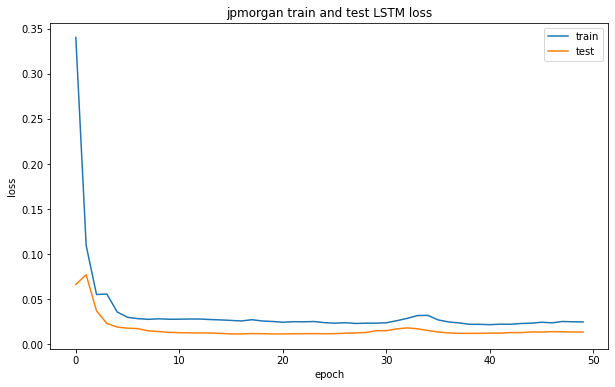

In [21]:
# 搭建LSTM模型
model=tf.keras.models.Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.122))
model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2,shuffle=False)

# 绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('jpmorgan train and test LSTM loss', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [22]:
#模型预测收益率
y_predict = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [23]:
# invert scaling for forecast
#将预测结果按比例反归一化
inv_y_test = np.concatenate((test_X1[:, :3],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]

# invert scaling for actual
#将真实结果按比例反归一化
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X1[:, :3],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('反归一化后的预测结果：',inv_y_predict)
print('反归一化后的真实结果：',inv_y)

反归一化后的预测结果： [151.92876  152.20717  153.83765  ... 111.19788  110.824295 108.790985]
反归一化后的真实结果： [153. 160. 161. ... 107.  98. 107.]


In [24]:
inv_y_predict

array([151.92876 , 152.20717 , 153.83765 , ..., 111.19788 , 110.824295,
       108.790985], dtype=float32)

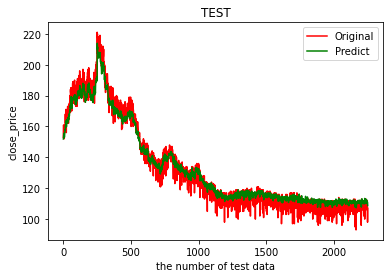

In [25]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('close_price')
plt.title('TEST')
plt.legend()
plt.show()

In [26]:
#回归评价指标
# calculate MSE 均方误差
mse=mean_squared_error(inv_y,inv_y_predict)
# calculate RMSE 均方根误差
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(inv_y,inv_y_predict)
#calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)
print('MAE: %.6f' % mae)
print('R_square: %.6f' % r_square)

MSE: 27.138670
RMSE: 5.209479
MAE: 4.068237
R_square: 0.969689


In [29]:
df_new=df_s[4000:]
predict_closeprice=pd.Series(inv_y_predict,index=df_new.index)
predict_closeprice

period
2025-04-28-1     152.052261
2025-04-28-2     152.442184
2025-04-28-3     154.090729
2025-04-28-4     155.025620
2025-04-28-5     155.110199
                    ...    
2025-07-01-46    110.052704
2025-07-01-47    109.887672
2025-07-01-48    109.707230
2025-07-01-49    109.346497
2025-07-01-50    107.335434
Length: 2250, dtype: float32

In [30]:
df_new["predict_closeprice"]=predict_closeprice
df_new.index.name = None
df_new

C:\Users\14620\AppData\Local\Temp/ipykernel_5320/2518012641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["predict_closeprice"]=predict_closeprice


,max_price,min_price,open_price,close_price,predict_closeprice
2025-04-28-1,160,140,158,153,152.052261
2025-04-28-2,161,144,152,160,152.442184
2025-04-28-3,162,142,158,161,154.090729
2025-04-28-4,162,141,161,160,155.025620
2025-04-28-5,160,140,160,154,155.110199
...,...,...,...,...,...
2025-07-01-46,113,93,109,110,110.052704
2025-07-01-47,113,93,109,109,109.887672
2025-07-01-48,113,93,109,107,109.707230
2025-07-01-49,113,93,107,98,109.346497


In [32]:
df_new.rename(columns={'max_price': 'High', 'min_price': 'Low','open_price': 'Open','predict_closeprice': 'Close'}, inplace=True)
df_new=df_new.drop(["close_price"],axis=1)
df_new

C:\Users\14620\AppData\Local\Temp/ipykernel_5320/434174716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.rename(columns={'max_price': 'High', 'min_price': 'Low','open_price': 'Open','predict_closeprice': 'Close'}, inplace=True)


,High,Low,Open,Close
2025-04-28-1,160,140,158,152.052261
2025-04-28-2,161,144,152,152.442184
2025-04-28-3,162,142,158,154.090729
2025-04-28-4,162,141,161,155.025620
2025-04-28-5,160,140,160,155.110199
...,...,...,...,...
2025-07-01-46,113,93,109,110.052704
2025-07-01-47,113,93,109,109.887672
2025-07-01-48,113,93,109,109.707230
2025-07-01-49,113,93,107,109.346497


In [33]:
new_order = ['Open', 'High', 'Low','Close']
df_new=df_new[new_order]

In [34]:
df_new.to_csv("E:/git/dsmp-2024-group22/data_preprocess/DATA/LSTM_prediction.csv")